In [1]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
my_seed = 2024
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(my_seed)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(my_seed)

# Force TensorFlow to use single thread. (to force it set the threads to 1)
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(my_seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

rn.seed(my_seed)
#--- all other imports
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras.backend
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.optimizers import SGD, Adam
from numpy.random import seed
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.externals import joblib
from sklearn.model_selection import cross_validate
from sklearn.metrics import average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import copy
from bioinformatics_helpers.utils import get_mendelian_dataset
from bioinformatics_helpers.utils import hingesig_tf
from bioinformatics_helpers.utils import GetAUPRCCallback
from bioinformatics_helpers.balanced_generator import BalancedGenerator
from bioinformatics_helpers.utils import CustomKerasClassifier

import dill

Using TensorFlow backend.


In [2]:
feature_per_example = 26
batch_size = 5000

In [3]:
def create_model(architecture=(100,), dropout_rate=0.2):
    model = Sequential()
    weights_initializer = keras.initializers.glorot_normal(seed=my_seed)
    bias_init = keras.initializers.RandomNormal(mean=0.1, stddev=0.05, seed=my_seed)
    input_dim = feature_per_example
    for units in architecture:
        model.add(
            Dense(
                units,
                input_dim = input_dim,
                kernel_initializer = weights_initializer,
                bias_initializer = bias_init,
                activation="relu"
            )
        )
        input_dim=None # for the next layer keras infers its dimensions
        model.add(
            Dropout(rate=dropout_rate, seed=my_seed)
        )
        
    model.add(
        Dense(
            1,
            kernel_initializer=weights_initializer,
            bias_initializer=keras.initializers.zeros(),
            activation='sigmoid'
    ))
    optimizer = Adam()
    model.compile(loss=hingesig_tf, optimizer=optimizer)
    return model

In [4]:
create_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2700      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,801
Trainable params: 2,801
Non-trainable params: 0
_________________________________________________________________


In [5]:
train_X, train_y, test_X, test_y = get_mendelian_dataset()
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = scaler.transform(train_X)
scaled_test_X = scaler.transform(test_X)
callback = GetAUPRCCallback(test_X=scaled_test_X, test_y=test_y, train_X=scaled_train_X, train_y=train_y)

In [6]:
gen = BalancedGenerator
model = CustomKerasClassifier(build_fn = create_model,
                              generator=gen,
                              verbose=1,
                              shuffle=True,
                              epochs=100,
                              np_ratio=5,
                              positive_sample_perc=1.5,
                              negative_perc=1)
history = model.fit(scaled_train_X, train_y, callbacks=[callback])

Epoch 1/100
368/368 [==============================] - 15s 40ms/step - loss: 0.1017
Epoch 2/100
368/368 [==============================] - 15s 40ms/step - loss: 0.0502
Epoch 3/100
368/368 [==============================] - 15s 41ms/step - loss: 0.0399
Epoch 4/100
368/368 [==============================] - 15s 42ms/step - loss: 0.0328
Epoch 5/100
368/368 [==============================] - 15s 40ms/step - loss: 0.0273
Epoch 6/100
368/368 [==============================] - 15s 41ms/step - loss: 0.0233
Epoch 7/100
368/368 [==============================] - 15s 40ms/step - loss: 0.0199
Epoch 8/100
368/368 [==============================] - 15s 41ms/step - loss: 0.0171
Epoch 9/100
368/368 [==============================] - 15s 40ms/step - loss: 0.0147
Epoch 10/100
368/368 [==============================] - 15s 42ms/step - loss: 0.0129
Epoch 11/100
368/368 [==============================] - 15s 40ms/step - loss: 0.0116
Epoch 12/100
368/368 [==============================] - 12s 34ms/step - lo

In [21]:
test_auprc = pd.Series(callback.test_AUPRC, name="test_AUPRC")
train_auprc = pd.Series(callback.train_AUPRC, name="train_AUPRC")
pd.DataFrame([test_auprc, train_auprc]).to_csv("data/test_train_history_model_dropout_scaling_adam_mb_gen_100.csv")

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
def plot_AUROC_AUPRC(y_true, probas_pred, c):
    p,r,_= precision_recall_curve(y_true=y_true, probas_pred=probas_pred)
    fig, (ax,ax2) = plt.subplots(1,2,figsize=(11,6))
    ax.grid()
    
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.fill_between(r,p, alpha=0.1,color=c)
    ax.plot(r,p,color=c)
    auc_text ="AUPRC: {:.3f}".format(auc(x=r,y=p))
    ax.text(x=0.25, y=0.47, s=auc_text, fontsize=20)
    
    fpr,tpr,_ = roc_curve(y_true=y_true, y_score=probas_pred)
    ax2.set_xlabel("False positive rate")
    ax2.set_ylabel("True positive rate")
    ax2.fill_between(fpr,tpr,color=c, alpha=0.1)
    ax2.grid()
    ax2.plot(fpr,tpr, color=c)
    auc_text ="AUROC: {:.3f}".format(auc(x=fpr,y=tpr))
    ax2.text(x=0.25, y=0.47, s=auc_text, fontsize=20)
    return fig, (ax,ax2)

In [8]:
probas_train = model.predict_proba(scaled_train_X)

981388/981388 [==============================] - 67s 68us/step


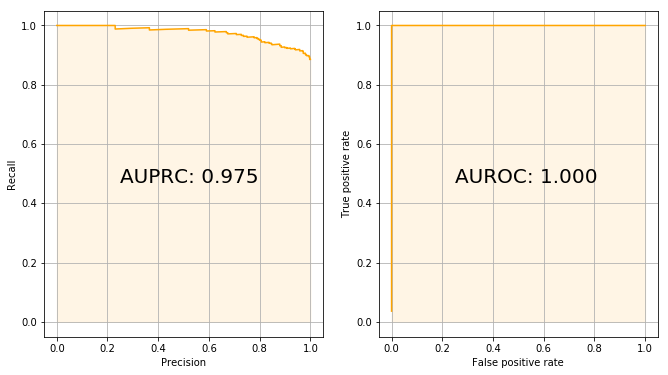

In [9]:
_, (p1, p2) = plot_AUROC_AUPRC(train_y, probas_train[:,1], c= "orange")

In [10]:
probas_test = model.predict_proba(scaled_test_X)

19018/19018 [==============================] - 2s 88us/step


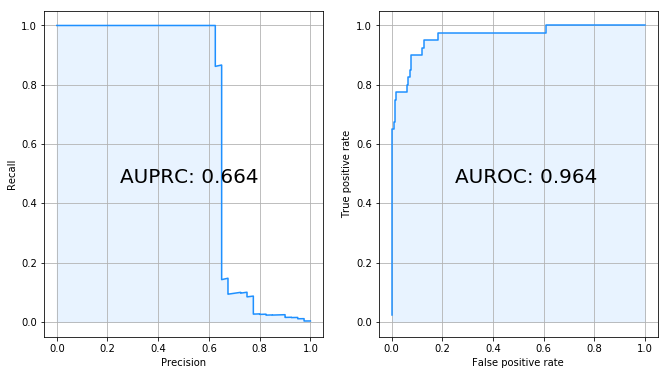

In [11]:
_, (p3, p4) = plot_AUROC_AUPRC(test_y, probas_test[:,1], c="dodgerblue")

In [12]:
def get_moving_average(data, window_width=8):
    window_width = 8
    padded_data = np.insert(data,0,[0]*window_width)
    cumsum = np.cumsum(padded_data) 
    moving_avg_data = (cumsum[window_width:] - cumsum[:-window_width]) / window_width
    return moving_avg_data

In [28]:
df = pd.read_csv("data/test_train_history_model_dropout_scaling_adam_mb_gen_100.csv")
df = df.T.drop("Unnamed: 0", axis=0)
df = df.rename({0:"test_AUPRC", 1:"train_AUPRC"}, axis=1)
df.head()

,test_AUPRC,train_AUPRC
0,0.563474,0.259246
1,0.708344,0.406095
2,0.733675,0.555598
3,0.755929,0.660433
4,0.726167,0.705172


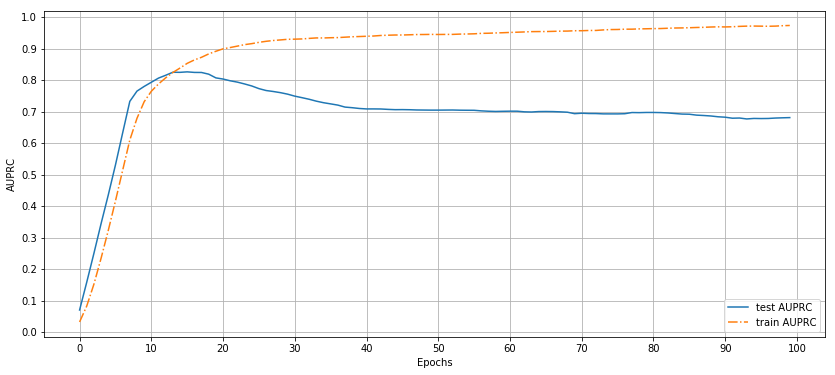

In [34]:
fig, (ax) = plt.subplots(1,1,figsize=(14,6))

data = get_moving_average(df.test_AUPRC.values)
ax.plot(data, label="test AUPRC")

data = get_moving_average(df.train_AUPRC.values)
ax.plot(data, label="train AUPRC", linestyle="-.")

ax.grid()
ax.set_xticks(np.linspace(0,100,11))
ax.set_yticks(np.linspace(0,1,11))
ax.set_xlabel("Epochs")
ax.set_ylabel("AUPRC")
ax.legend(loc=4)
plt.show()